In [26]:
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np
import pickle

In [27]:
os.chdir("C:\\Users\\Admin\\FingerprintClassification\\model")
from preprocess.preprocessing3 import preprocessing_normal

In [28]:
def read_data(label2num):
    id_anh = 0
    X=[]
    Y=[]
    #output_folder = "C:\\Users\\ADMIN\\FingerprintClassification\\model\\preprocessed_fingerprint"
    for label in os.listdir(os.path.join("preprocessed_fingerprint")):
        id_anh+=1
        img = cv2.imread(os.path.join('preprocessed_fingerprint',str(id_anh)+'.png'))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        X.append(img)
        Y.append(label2num["fingerprint"])
        if id_anh>=4000: break
    for label in os.listdir(os.path.join("preprocessed_fingerprint")):
        id_anh+=1
        img = cv2.imread(os.path.join('preprocessed_fingerprint',str(id_anh)+'.png'))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        X.append(img)
        Y.append(label2num["fingerprint_noise"])
        if id_anh>=8000: break
    return X,Y

In [29]:
label2num = {'fingerprint_noise':0, 'fingerprint':1}
X, Y = read_data(label2num)
print(len(X))
print(len(Y))

8000
8000


(256, 256)


(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

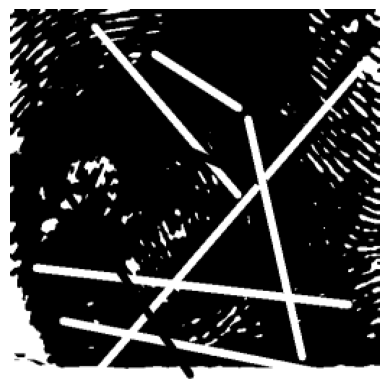

In [30]:
plt.imshow(X[7750], cmap='gray')
print(X[7750].shape)
plt.axis("off")

In [31]:
from skimage import feature

In [68]:
cell_size = (16, 16)  # h x w in pixels
block_size = (2, 2)  # h x w in cells
nbins = 4  # number of orientation bins
def hist_vec(X):
    vector_HoG = []
    for i in range(len(X)):
        img = X[i]
        # 1. Khai báo các tham số
        #cell_size = (8, 8)  # h x w in pixels
        #block_size = (2, 2)  # h x w in cells
        #nbins = 9  # number of orientation bins

        # 2. Tính toán các tham số truyền vào HOGDescriptor
        # winSize: Kích thước của bức ảnh được crop để chia hết cho cell size.
        # blockSize: Kích thước của 1 block
        blockSize = (block_size[1] * cell_size[1], block_size[0] * cell_size[0])
        # blockStride: Số bước di chuyển của block khi thực hiện chuẩn hóa histogram bước 3
        blockStride = (cell_size[1], cell_size[0])

        # 3. Compute HOG descriptor
        hog = cv2.HOGDescriptor(_winSize=img.shape,
                                _blockSize=blockSize,
                                _blockStride=blockStride,
                                _cellSize=cell_size,
                                _nbins=nbins)

        # Kích thước của lưới ô vuông.
        n_cells = (img.shape[0] // cell_size[0], img.shape[1] // cell_size[1])
        
        # Reshape hog feature
        hog_feats = hog.compute(img)\
                    .reshape(n_cells[1] - block_size[1] + 1,
                                n_cells[0] - block_size[0] + 1,
                                block_size[0], block_size[1], nbins) \
                    .transpose((1, 0, 2, 3, 4))  
        #H = feature.hog(img, orientations=9, pixels_per_cell=(8, 8),
        #            cells_per_block=(2, 2), transform_sqrt=True, block_norm="L2")
        H = hog_feats.flatten()
        vector_HoG.append(H)
        #print('Kích thước hog features: ', H.shape)
    return vector_HoG

In [69]:
vector_HoG = hist_vec(X)

In [70]:
print('Kích thước hog features: ', vector_HoG[0].shape)

Kích thước hog features:  (3600,)


In [48]:
from sklearn.model_selection import train_test_split, learning_curve

In [71]:
X_train = []
X_test = []
Y_train = []
Y_test = []
X_train, X_test, Y_train, Y_test = train_test_split(vector_HoG, Y, test_size = 0.2, random_state=42)
print(len(X_train), " ", len(X_test))

6400   1600


In [62]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb
from sklearn.svm import SVC

In [72]:
lgbm = lgb.LGBMClassifier(class_weight="balanced").fit(X_train, Y_train)
print(lgbm.score(X_train, Y_train))
print(lgbm.score(X_test, Y_test))

[LightGBM] [Info] Number of positive: 3196, number of negative: 3204
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.197055 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 918000
[LightGBM] [Info] Number of data points in the train set: 6400, number of used features: 3600
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
0.99953125
0.759375


In [73]:
log = LogisticRegression().fit(X_train, Y_train)
print(log.score(X_train, Y_train))
print(log.score(X_test, Y_test))

0.819375
0.728125


C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [40]:
clf = AdaBoostClassifier(algorithm='SAMME')
clf.fit(X_train, Y_train)
print(clf.score(X_train, Y_train))
print(clf.score(X_test, Y_test))

0.77703125
0.72875


In [41]:
dtree = DecisionTreeClassifier().fit(X_train, Y_train)
print(dtree.score(X_train, Y_train))
print(dtree.score(X_test, Y_test))

1.0
0.649375


In [75]:
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train,Y_train)
print(knn.score(X_train, Y_train))
print(knn.score(X_test, Y_test))

0.64421875
0.568125


In [76]:
rf = RandomForestClassifier(n_estimators=12,max_depth=20)
rf.fit(X_train, Y_train)
print(rf.score(X_train, Y_train))
print(rf.score(X_test, Y_test))

0.985
0.68


In [45]:
sv = SVC(kernel = 'linear')
sv.fit(X_train, Y_train)
print(sv.score(X_train, Y_train))
print(sv.score(X_test, Y_test))

1.0
0.74


In [ ]:
sv = SVC(kernel = 'rbf')
sv.fit(X_train, Y_train)
print(sv.score(X_train, Y_train))
print(sv.score(X_test, Y_test))